Task Breakdown:
* Barcode Detection* (I will not use some AI to save computational power)
* Barcode Decoding - Extract the numerical code. Own implementation

Test my solution against benchmark solutions - Pyzbar, Zxing, Dynamsoft..

Input:
* All images from the current folder.
Output:
* A text or CSV file containing the decoded numbers, indexed by image filename
* Example output images with optional visualizations (e.g., detection boxes, signal profiles, etc.)


In [1]:
import numpy as np
import cv2, os

def create_input_list(input_dir):
    input_list = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                input_list.append(os.path.join(root, file))
    return input_list


input_directory = r'/home/costin/Documents/Github/ComputerVision/2_barcodes'
images = create_input_list(input_directory)
print(f"Found {len(images)} images:")

Found 6 images:


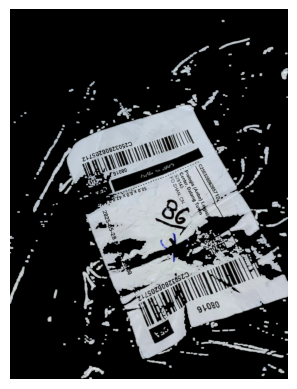

In [10]:
def preprocessing(image_path):
    img = cv2.imread(image_path).copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # HSV = Hue, Saturation, Value
    msk = cv2.inRange(hsv, np.array([0, 0, 200]), np.array([179, 60, 255])) # Isolate white-like regions
    msk = cv2.GaussianBlur(msk, (5, 5), 0) # Much better results with GaussianBlur than median blur
    # Morph to connect broken pieces
    krn = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
    dlt = cv2.dilate(msk, krn, iterations=1)

    return cv2.bitwise_and(img, img, mask=dlt)

import random
preprocessed_image = preprocessing(images[random.randint(0, len(images) - 1)]) # run multiple times to see different results.
import matplotlib.pyplot as plt
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()


(-0.5, 851.5, 850.5, -0.5)

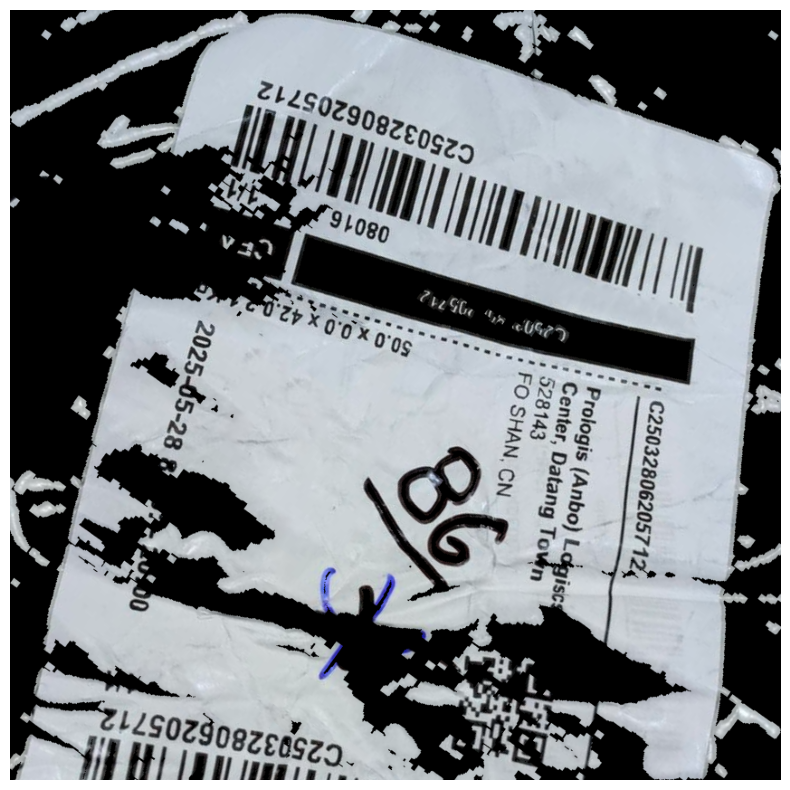

In [11]:
def extract_largest_white_region(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 10000 # Empirical value
    large_contours = [c for c in contours if cv2.contourArea(c) > min_area]

    # Stack all large contours together. Source: https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html - section 7.b
    best_contour = max(large_contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(best_contour) # Get the minimum-area rotated rectangle around all contours
    box = cv2.boxPoints(rect)
    box = np.intp(box) # int0 is deprecated
    # extract width and height of the rect. rect = [center, (width, height), and angle]
    width = int(rect[1][0])
    height = int(rect[1][1])
    angle = rect[2]

    if height > width: # Ensure width > height. Otherwise, rotation doesn't really make sense.
        width, height = height, width
        box = np.roll(box, 1, axis=0)

    # Define destination points for perspective transform
    dst_pts = np.array([
        [0, height - 1], # bottom-left
        [0, 0], # top-left
        [width - 1, 0], # top-right
        [width - 1, height - 1] # bottom-right
        ], dtype="float32")

    src_pts = box.astype("float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts) # Transformation matrix. Includes rotation, scaling, and translation.
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

barcodes_contours = extract_largest_white_region(preprocessed_image)
plt.figure(figsize=(10, 10))
plt.imshow(barcodes_contours)
plt.axis('off')
